# Introduction

In this example, we will analyse a ROOT file containing inclusive $e^+ e^- \to Z^0 \to b\bar{b}$ events generated with Pythia and Delphes in FCCSW. The command used to generate this sample is:

`
./run fccrun Sim/SimDelphesInterface/options/PythiaDelphes_config_IDEA.py --Filename Generation/data/ee_Z_bbbar.cmd -n 10000
`

where the `ee_Z_bbbar.cmd` file was created from the `ee_Z_ddbar.cmd` example by changing the quark number to `5` (for $b$-quarks). The config file is based on the options shown [here](https://github.com/clementhelsens/fcc-tutorials/blob/9ab4f18c8ded529204e0077d9e4bca1a133a59a8/FCCsnowmass.md). The ROOT file is loaded using the `uproot` package, and the goal of the analysis is to produce an invariant mass peak for the $D^0 \to K^- \pi^+$ decay. 

The $b$-quarks produced in the $Z^0$ decay quickly hadronise to different types of $b$-hadrons such as $B^0$, $B^\pm$, and $B_s^0$ mesons. Many $D^0$ mesons are then produced when these mesons decay, due to the favoured nature of the $b \to c$ quark transition. Around 4% of the $D^0$ mesons then decay to a kaon and a pion. To search for the $D^0 \to K^- \pi^+$ decay, we make combinations of kaons and pions using the `awkward array` package.

## First some imports of what we need

We load `uproot4` (will eventually be called just `uproot`) and `awkward1` (will eventually be just `awkward`) to load the ROOT files and analyse them. We load `numpy` for some numerical operations, and `matplotlib` for plotting. We will make use of the `particle` package to give us information on the PDG ID and mass of various particles. We also load functions from the main project code directory `fcc_python_tools`.  

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

## Loading the ROOT file with uproot

Now we load the ROOT tree using `uproot`, where we point it at the data location `loc.DATA` as defined in `python/locations.py`. The TTree is called `events` in the FCC simulation output.

In [2]:
file = uproot.open(f"{loc.DATA}/FCCDelphesOutput.root")
tree = file['events']

We can check how many events are in our tree - this should match the number of events generated in Pythia.

In [3]:
tree.num_entries

10000

A useful summary of the tree contents is given by the `show()` function, which shows the name, ROOT variable type, and type as interepted by `uproot` and `awkward array`.

In [4]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
genParticles         | vector<fcc::MCParticl... | AsGroup(<TBranchElement 'ge...
genParticles/genP... | int32_t[]                | AsJagged(AsDtype('>i4'))
genParticles/genP... | int32_t[]                | AsJagged(AsDtype('>i4'))
genParticles/genP... | uint32_t[]               | AsJagged(AsDtype('>u4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genParticles/genP... | float[]                  | AsJagged(AsDtype('>f4'))
genPart

## Accessing specific particles

Next we get the stable charged hadrons and load them into an `awkward array`. The charged hadrons live in the `pfcharged` container in the ROOT file. There are also locations like `muons`, `electrons`, and `photons`, which you can also access in the same way.

Note that we use a wildcard `*` here, which loads all of the branches under the name `pfcharged.core`. We use the `zip` command as a handy way to group all the branches of the hadrons together.

In [5]:
h_container = "efcharged.core"
h = tree.arrays(filter_name=f"{h_container}*",how="zip")

## Calculating some new variables and making cuts

Because `awkward array` operates at array level, we can process all events and particles in each event with single line commands. Loops can also be written, and even sped up using `numba`, but we won't consider this here.

Here we calculate the $p$ and $p_T$ of the hadrons, using the existing momentum components stored in the ROOT file.

In [6]:
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)
h[h_container,'p4.pt'] = kinematics.calc_pt(h,h_container)
h[h_container,'p4.phi'] = kinematics.calc_phi(h,h_container)
h[h_container,'p4.eta'] = kinematics.calc_eta(h,h_container)

Note the syntax here - because we zipped the array, we can access specific branches with `h[h_container,var_name]`. As a reminder, `h_container` is the location of the hadrons in the ROOT file (`pfcharged.core`). We follow the same syntax when calculating a new variable - so `p4.p` and `p4.pt` are added as new branches for our hadrons.

The `kinematics.calc_p/pt` functions come from the `fcc_python_tools` directory of this project - they are not `awkward array` methods. If you want to calculate more variables, you can add them into `fcc_python_tools` or just define them directly in your code. Generally, if you are going to reuse the function in several places, it's best to put it somehwere general. 

Now that we have a $p$ branch, we can define a cut to apply on it like this:

In [7]:
p_cut = h[h_container,"p4.p"] > 2.

This requires that all of the hadrons we want to consider have $p > 2$ GeV. To apply this cut to the hadrons, we do:

In [8]:
h = h[p_cut]

In the same way, we can get samples of pions and kaons from our general hadrons array by cutting on the `pdgId`. We add them as extra members of our `h` array like this:

In [9]:
pi_cut = abs(h[h_container,"pdgId"]) == abs(lp.pi_plus.pdgid)
h["pi"] = h[h_container][pi_cut]

k_cut = abs(h[h_container,"pdgId"]) == abs(lp.K_plus.pdgid)
h["k"] = h[h_container][k_cut]

Here we have made use of the [particle](https://github.com/scikit-hep/particle) package, which provides access to various bits of information on PDG particles. We specifically use the `literals` module, which provides shortcuts to a bunch of common particles - these can be found [here](https://github.com/scikit-hep/particle/blob/master/src/particle/shared_literals.py). When we do `lp.pi_plus.pdgid`, we are getting the PDG ID of the pion.


## Making particle combinations

There are extremely helpful combinatorics functions provided by `awkward array`, namely `combinations()` for particles in the same container and `ak.cartesian()` for particles from different containers. We can use the `cartesian()` function to find all $K\pi$ pairs in every event. 

In [10]:
D = ak.cartesian({"k": h["k"], "pi": h["pi"]})

Our kaons and pions are both positively and negatively charged. For physical track combinations, we want the kaon and pion to have opposite charge. We can do this with a cut as follows:

In [11]:
D_cut = np.sign(D["k","pdgId"]) != np.sign(D["pi","pdgId"])
D = D[D_cut]

Now we can calculate the invariant mass of our $K\pi$ pairs, and look for a $D^0$ peak! To get access to the kaon and pions used to form the D, we can do:

In [12]:
D_k, D_pi = ak.unzip(D)

and then pass those into a function to calculate their combined invariant mass. This function also takes as input the rest mass of the kaon and pion, which are required in order to calculate the track energies. We take the masses from the `particle` package, again accessing the information via the `literals` module. So `lp.K_plus.mass` gives us the rest mass of the charged kaon.

In [13]:
PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics.mass_2body(D_k, D_pi, PDG_K_m, PDG_pi_m)

To look at only those $K\pi$ combinations consistent with a $D^0$, we can cut around the PDG $D^0$ mass:

In [14]:
PDG_D_m = lp.D_0.mass/1000.
D_cut = abs(D["mass"] - PDG_D_m) < 0.025
D = D[D_cut]

We now make a quick histogram of the $K\pi$ invariant mass, using the `matplotlib` `hist` function:

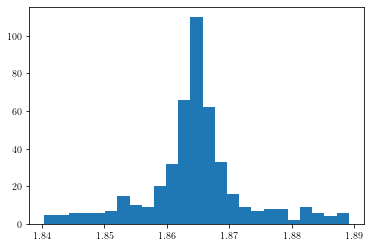

In [15]:
plt.hist(ak.flatten(D["mass"]), bins=25)
plt.show()

Note the use of `ak.flatten()` here, which is the `awkward array` function that turns the jagged data into non-jagged (which `matplotlib` requires). What this means in pratice is that all $D^0$ candidates from all events are shown together - so if an event happens to contain two $K\pi$ combinations passing our requirements, both of them will be added to the histogram.

## Pretty plotting

An example function which takes the `D["mass"]` values and plots them in a pretty error bar plot is provided. It is run with:

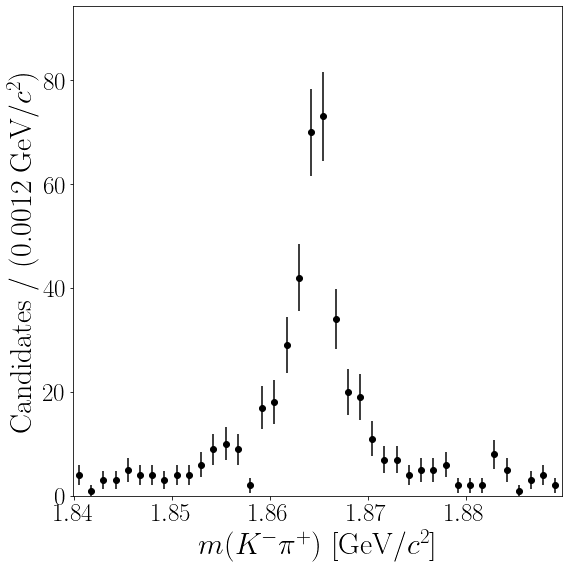

In [18]:
low = PDG_D_m - 0.025
high = PDG_D_m + 0.025
plotting.errorbar_hist(D,"mass","D","$m(K^- \pi^+)$ [GeV/$c^2$]",low,high,40)

Here we pass the function the array containing our D candidates (`D`), the variable we want to plot ("mass"), the name of the particle which gets added to the output file name for the plot ("D"), the x-axis title, and the histogram lower and upper limits.